# Ultimate Data Science Challenge!

This notebook will be solving the problems featured in the Sprignboard Ultimate Data Science Challenge.

## Part 3: Predictive modeling

In [1]:
# Begin by importing the packages and file.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix

# Open and store the file to json_data
with open(r'C:\Users\joshu\Downloads\1481053515_ultimate_challenge\ultimate_challenge\ultimate_data_challenge.json') as f:
    data = json.load(f)

C:\Users\joshu\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Convert json data to a dataframe 
df = pd.DataFrame(data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Data Wrangling 

In [5]:
# Convert the dates into datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
# Fill in the missing data using the mean of the values
mean1 = np.mean(df['avg_rating_by_driver'])
df['avg_rating_by_driver'].fillna(mean1, inplace = True)

mean2 = np.mean(df['avg_rating_of_driver'])
df['avg_rating_of_driver'].fillna(mean2, inplace = True)

# For the phone column, fill the missing data with 'unknown'
df['phone'].fillna('unknown', inplace = True)

In [7]:
from datetime import timedelta

# Create a column for labeling retained users (active within the last 30 days)
retention_date = df['last_trip_date'].max() 
df['retained'] = df['last_trip_date'] >= retention_date - timedelta(days = 30)

Since last_trip_date is directly responsible for creating the retained column, we will need to remove it or it will result in data leakage (in other words, 100% accuracy in prediction).

In [8]:
# Drop last_trip_date
df.drop('last_trip_date', axis = 1, inplace = True)

In [9]:
# Set signup_date as the index
df.set_index('signup_date', inplace=True)

## Data Exploration

In [10]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


- The average distance traveled was 5.79 miles in the first 30 days of signing up.

- The average rating of the client was 4.77.

- The average rating of the driver was 4.60.

- The average surge multiplier was 1.07.

- The average number of trips in the first 30 days was 2.28.

- The average percentage of trips taken on a weekday was 60.92%.

In [11]:
len(df[df['retained'] ==  True])

18804

In [12]:
len(df[df['retained'] == True])/len(df)

0.37608

Out of the 50,000 different clients that signed up in January of 2014, 37.61% of them were considered "retained". In other words, 18,804 have used Ultimate's service within the last 30 days (the month of June).

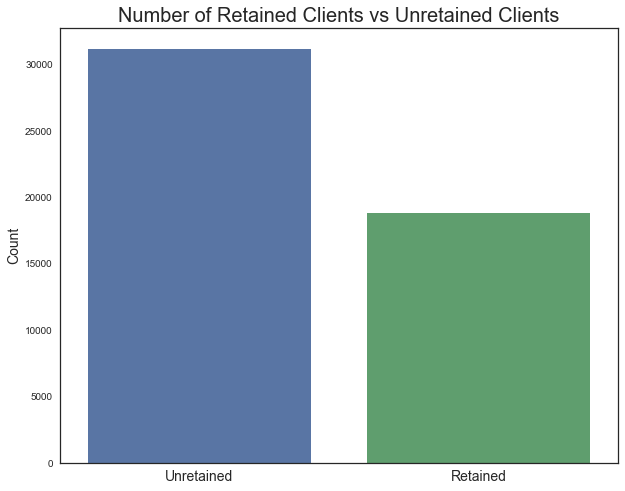

In [13]:
sns.set(style="white")

plt.figure(figsize = (10,8))
sns.countplot(x = 'retained', data = df)
plt.title('Number of Retained Clients vs Unretained Clients', fontsize = 20)
plt.xticks([0,1],['Unretained','Retained'], fontsize = 14)
plt.xlabel('')
plt.ylabel('Count', fontsize = 14)
plt.show()

In [14]:
pd.crosstab(df['trips_in_first_30_days'], df['retained']).head(10)

retained,False,True
trips_in_first_30_days,,
0,9810,5580
1,10983,3125
2,4659,2743
3,2095,1693
4,1249,1313
5,690,926
6,477,657
7,331,488
8,200,389


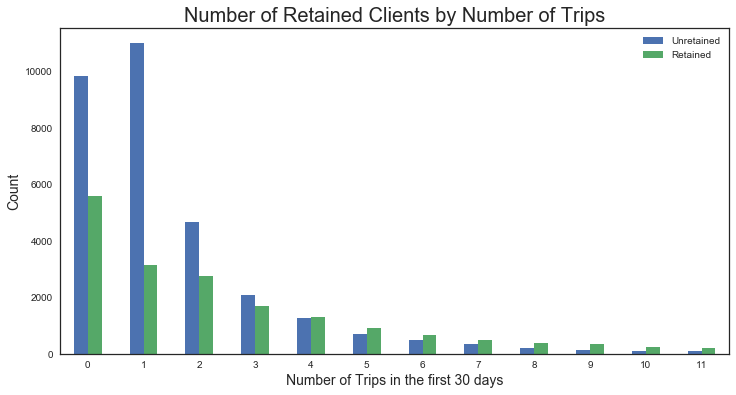

In [15]:
pd.crosstab(df['trips_in_first_30_days'], df['retained']).iloc[0:12,:].plot(kind='bar', figsize = (12,6))
plt.title('Number of Retained Clients by Number of Trips', fontsize = 20)
plt.xticks(rotation = 0)
plt.xlabel('Number of Trips in the first 30 days', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(['Unretained','Retained'])
plt.show()

- Most clients (both retained and unretained) opt not to take more than 2 trips within the first 30 days of signing up.

- There are more unretained clients when they choose to take less than 4 trips in the first 30 days of signing up. However, there are more retained clients when they take 4 or more trips. This could be due to the fact that clients are more likely to build loyalty after repeatedly using Ultimate's services.

- After 6 trips, the distribution in the number of clients begins to decrease at a slower pace. That is, the number of clients who take 8 trips is similar to those who take 9 or 10 whereas there is a much bigger difference between those who take 1 trip and others who take 2 trips. This is most likely due to sample size.

In [16]:
pd.crosstab(df['ultimate_black_user'], df['retained'])

retained,False,True
ultimate_black_user,,
False,21839,9307
True,9357,9497


In [17]:
df.groupby('ultimate_black_user')['retained'].mean()

ultimate_black_user
False    0.298818
True     0.503713
Name: retained, dtype: float64

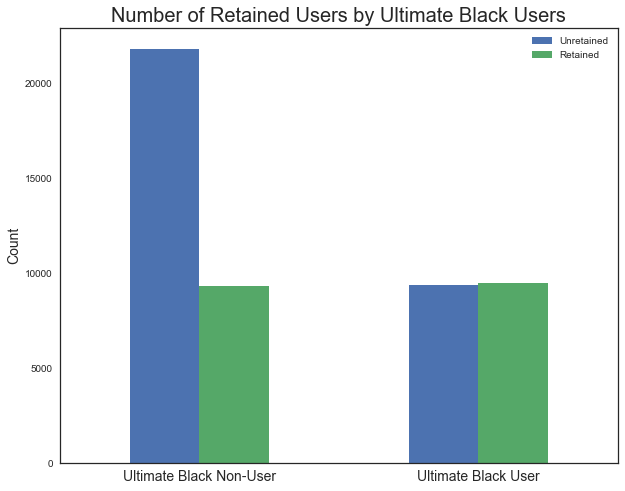

In [18]:
pd.crosstab(df['ultimate_black_user'], df['retained']).plot(kind='bar', figsize=(10,8))
plt.title('Number of Retained Users by Ultimate Black Users', fontsize = 20)
plt.xticks([0,1], ['Ultimate Black Non-User', 'Ultimate Black User'], rotation=0, fontsize = 14)
plt.xlabel('')
plt.ylabel('Count', fontsize = 14)
plt.legend(['Unretained', 'Retained'])
plt.show()

- The number of retained clients for is approximately the same whether they use Ultimate Black or not.

- However, the retention rate for Ultimate Black users is much higher (**50.37%**) compared to those who don't use it (**29.88%**).

In [19]:
df.groupby('city')['retained'].agg(['mean', 'count'])

,mean,count
city,,
Astapor,0.255715,16534
King's Landing,0.628134,10130
Winterfell,0.351945,23336


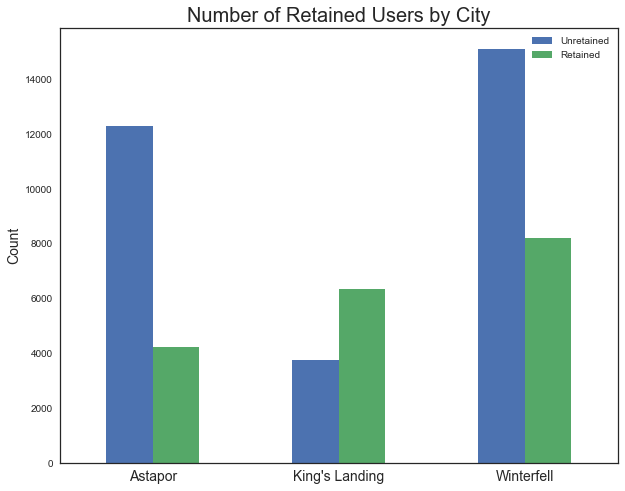

In [20]:
pd.crosstab(df['city'], df['retained']).plot(kind='bar', figsize=(10,8))
plt.title('Number of Retained Users by City', fontsize = 20)
plt.xticks(rotation=0, fontsize = 14)
plt.xlabel('')
plt.ylabel('Count', fontsize = 14)
plt.legend(['Unretained', 'Retained'])
plt.show()

- Clients from Astapor and Winterfell were much less likely to be active compared to clients from King's Landing.

- Astapor had a 25.57% retention rate, Winterfell had 35.19% and King's Landing had 62.81%.

- Winterfell had the most clients (23336) while King's Landing had the fewest (10130).

In [21]:
df.groupby('phone')['retained'].agg(['mean', 'count'])

,mean,count
phone,,
Android,0.209426,15022
iPhone,0.448933,34582
unknown,0.335859,396


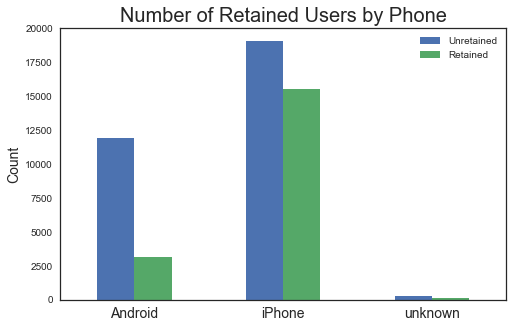

In [22]:
pd.crosstab(df['phone'], df['retained']).plot(kind='bar', figsize=(8,5))
plt.title('Number of Retained Users by Phone', fontsize = 20)
plt.xlabel('')
plt.xticks(rotation=0, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(['Unretained', 'Retained'])
plt.show()

- Clients who have an iPhone have a higher retention rate (44.89%) compared to those with an Android (20.94%) or an unknown phone type (33.59%).

## Machine Learning - Predictive Modeling

The approach will be taking for building the predictive model is first by choosing what kind of problem this is, what machine learning algorithm would create the best solution and which metrics to use as the evaluation.

- Problem: We want to predict the **retention status of a client** (whether or not a client has been active in the last 30 days) and learn which features are the best predictors for it.


- Machine Learning algorithm: We will be using a **Random Forest Classifier** because some of the important features are categorical (phone, city, ultimate_black_user). 


- Evaluation Metrics: We will be focusing on **accuracy** (number of correct predictions/total number of predictions), **precision** (number of correct Retained labels/total number of Retained labels) and **recall** (number of correct Retained labels/total number of actual Retained users).


- Validity of the Model: When compared to other applicable Classification algorithms for this type of problem, the Random Forest Classifier is one of the better suited. It will do a better job than Logistic Regression when it comes to scaling since many of the features are unbalanced and not linearly separable.

In [23]:
# Begin by creating dummy variables for the categorical features
dummy_df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [24]:
# Create the feature and response variable sets
X = dummy_df.drop('retained', axis = 1)
y = dummy_df['retained']

In [25]:
# Begin by creating the pipeline steps. Start with scaling the data via StandardScaler and then the DummyRegressor estimator
steps = [('scaler', StandardScaler()), ('rf', RandomForestClassifier())]
pipeline = Pipeline(steps)
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# Fit the data into the pipeline
pipeline.fit(X_train,y_train)
# Predict the response variables using the test data
y_pred = pipeline.predict(X_test)

In [26]:
# Extract the Accuracy, Precision and Recall scores
print('Accuracy score of Random Forest classifier on test set: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))
print('Precision score of Random Forest classifier on test set: {:.4f}\n'.format(precision_score(y_test, y_pred)))
print('Recall score of Random Forest classifier on test set: {:.4f}'.format(recall_score(y_test, y_pred)))

Accuracy score of Random Forest classifier on test set: 0.7527

Precision score of Random Forest classifier on test set: 0.6922

Recall score of Random Forest classifier on test set: 0.6106


In [27]:
# Take a look at the classification report
print('Classification Report: \n\n', classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

      False       0.78      0.84      0.81      9386
       True       0.69      0.61      0.65      5614

avg / total       0.75      0.75      0.75     15000



In [28]:
# Take a look at the confusion matrix
print('Confusion Matrix: \n\n',confusion_matrix(y_test, y_pred))

Confusion Matrix: 

 [[7862 1524]
 [2186 3428]]


- **Accuracy**: The model was able to predict which clients would be retained with 75.28% accuracy. Using the confusion matrix, we can see that there were 11292 correct and 3708 incorrect predictions from the model. 

- **Precision**: 69.14% of the clients who were labeled as "Retained" by the model were actually retained and active in the last 30 days. The model also had a 78% precision score when labeling those who were "Not retained".

- **Recall**: 61.31% of clients who were actually retained were correctly labeled as "Retained" by the model. On the other hand, the model had an 84% recall score for correctly labeling those were "Not retained".

- Overall, this model does a good job in making its predictions and should be considered as part of consultation for deciding which features are most important for retaining clients.

In [29]:
# Organize the feature importances into a dataframe
rf_steps = pipeline.named_steps['rf'] # Use the .named_steps pipeline method to access random forest attributes
table_df = pd.DataFrame({'Features':np.array(X.columns), 'Importance':rf_steps.feature_importances_})
table_df.set_index('Features', inplace = True)
table_df.sort_values('Importance', ascending=False, inplace=True)
table_df

,Importance
Features,
avg_dist,0.296205
weekday_pct,0.137796
avg_rating_by_driver,0.128711
avg_rating_of_driver,0.082159
trips_in_first_30_days,0.079455
avg_surge,0.074901
city_King's Landing,0.060221
surge_pct,0.058776
phone_iPhone,0.036000


## Conclusion

Based on the feature importances, the 5 most important features in predicting the retention status of clients are:

**1) Average Distance** - It certainly seems plausible why the average distance would be an important feature for determining whether or not a client is retained. The average distance traveled using Ultimate's services would be a good measure of how much the client wants to use the product. In other words, someone who had a high average distance traveled in the first 30 days would more likely use Ultimate again compared to someone who did not use it much.

**2) Percentage of User's trips taking place on a weekday** - The percentage of trips taking place on a weekday is also another likely important feature because it could indicate whether or not the client uses it for work commuting purposes. For users who don't own a car or don't have access to public transportation, they may prefer to use Ultimate to get to work or other regular destinations. 

**3) Percentage of trips taken with a surge multiplier greater than 1**

**4) Average rating of the client**

**5) Average rating of the driver**

#### Recommendations:

- **Offer incentives for new users who travel more**

The data suggests that the average distance traveled in the first 30 days of signing up is the most important feature for determining whether or not the client will use the service again 6 months later. By providing them with incentives, this will give them an extra push for continuing to use Ultimate in the future since they are already likely to be retained. An example can be a loyalty program that rewards frequent users with a discount or even a free ride after they reach a milestone (ex. 50 miles traveled).

- **Create a new "Weekday" program**

Since the percentage of user's trips taking on a weekday is a strong indicator of a client's retention status, it could be worthwhile creating a new "Weekday" program (similar to the premium Ultimate Black service). Users who decide to pay extra to opt into the program will gain additional benefits such as discounted prices, access to drivers with higher ratings, lower queue-times and other rewards that can be discussed with the product team. On the other end, Ultimate should also cater to Weekday drivers by offering bonuses for those who reach a milestone (ex. driving 30 hours on the weekdays will result in a $100 bonus).

- **Incentivize drivers to provide better service**

As the saying goes, "First impressions matter". A client's first impression of Ultimate can ultimately be driven by their ineraction with the driver in their first ride. Ultimate could offer additional bonuses to those who have higher ratings by using a ranking system. Those who are among the highest ratings by the end of the week can earn bonus cash. The exact metrics can be determined by using other algorithms.